<img src="../../kerchunk.png" width=500 alt="Kerchunk Logo"></img>

# Kerchunk Basics

## Overview

This notebook is intended as an introduction to using kerchunk.
In this tutorial we will:
- Scan a single NetCDF file to create a kerchunk virtual dataset
- Learn how to use the output  using `xarray` and `fsspec`.

While this notebook only examines using kerchunk on a single NetCDF file, kerchunk can be used to create virutal zarr datasets from collections of many input files. In the following notebook, we will demonstrate this. 

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Basic features |

- **Time to learn**: 60 minutes
---

## Imports


In [3]:
import fsspec
import kerchunk.hdf
import ujson
import xarray as xr

### Parse a single NetCDF file with kerchunk

Below we will access a NetCDF file stored on the AWS cloud. This dataset is a single time slice of a climate downscaled product for Alaska.

In [4]:
# Options passed to fsspec
so = dict(anon=True, default_fill_cache=False, default_cache_type="first")

# Input URL to dataset. Note this is a netcdf file stored on s3 (cloud dataset).
url = "s3://wrf-se-ak-ar5/ccsm/rcp85/daily/2060/WRFDS_2060-01-01.nc"

# Uses kerchunk to scan through the netcdf file to create kerchunk mapping and then save output as .json
# Note: In this example, we write the kerchunk output to a .json file.
# You could also keep this information in memory and pass it to fsspec
with fsspec.open(url, **so) as inf:
    h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, url, inline_threshold=100)
    h5chunks.translate()
    with open("single_file_kerchunk.json", "wb") as f:
        f.write(ujson.dumps(h5chunks.translate()).encode())

#### Load Kerchunk Reference File

In [5]:
# use fsspec to create filesystem from .json reference file
fs = fsspec.filesystem(
    "reference",
    fo="./single_file_kerchunk.json",
    remote_protocol="s3",
    remote_options=dict(anon=True),
    skip_instance_cache=True,
)

# load kerchunked dataset with xarray
ds = xr.open_dataset(fs.get_mapper(""), engine="zarr")

/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/ipykernel_7074/2342211006.py:11: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_dataset(fs.get_mapper(""), engine='zarr')


### Plot Dataset

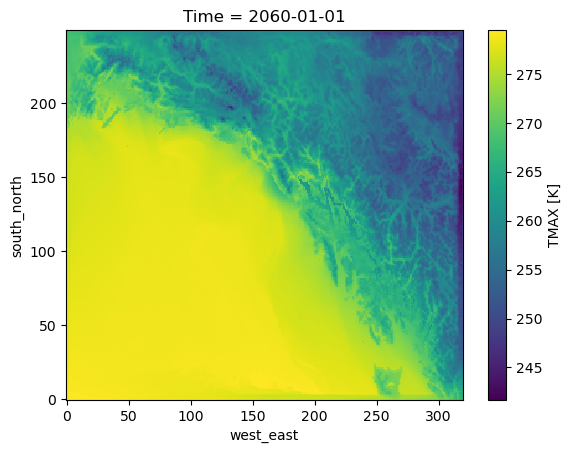

In [6]:
ds.TMAX.plot()